<a href="https://colab.research.google.com/github/sirleudo/sigmoidal_data_science/blob/master/Detec%C3%A7%C3%A3o_de_Fraude_em_Cart%C3%B5es_de_Cr%C3%A9dito.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

---
<img alt="Colaboratory logo" width="15%" src="https://github.com/sirleudo/sigmoidal_data_science/blob/master/logo_pensatah.png?raw=true">

#### **Data Science na Prática 2.0**
*by Sirleudo Evaristo*  

# Detecção de Fraudes em Cartões de Crédito
Com o crescente aumento de vendas realizadas por plataformas online e o uso de cartões de crédito sendo a opção mais usada pelos clientes, consequetemente aumenta as  fraudes nesse meio de pagamento. Esse projeto de pesquisa tem o intuito de abordar esse tipo de problema enfrentado aqui no Brasil, onde cerca de 12,1 milhões de usuários foram vítimas no último ano.  

<p align=center>
<img src="https://github.com/sirleudo/sigmoidal_data_science/blob/master/Cartoes_New_DESKTOP.jpg?raw=true" width="100%"></p>

Em 2019, um panorama desse tipo de fraude, apontou que de cada 45 compras feitas nas plataformas online, 1 tem origem fraudelenta. A cada 6,5 segundos, uma tentativa de fraude, ou seja, 553 por hora.

Segundo dados da **Serasa Experian** e uma pesquisa da *Global Consumer Card Fraud* o Brasil é o segundo maior país em número de fraudes com cartão de crédito. O percentual de golpes chega a 49%. Entre os motivos que levam a essa situação, o estudo destaca:

* questão cultural;
* redução de fraudes no varejo físico;
* crescimento do comércio eletrônico no País.

Os tipos de fraudes com cartão de crédito mais comuns são:
* clonagem de cartões;
* geradores de números de cartões;
* roubo de dados em ligações falsas;
* chargeback;
* troca de máquina.

O investimento em Inteligência Artificial para detectar essas fraudes, vem crecendo a cada ano, onde, cientistas de dados estão ganhamdo oportunidades no mercado para analisar grandes bancos de dados de renomadas instituições.

## Importando os Dados
Os dados que usaremos neste projeto foram disponibilizados por algumas empresas européias de cartão de crédito. O *dataset* representa as operações financeiras que aconteceram no período de dois dias, onde foram classificadas 492 fraudes em meio a quase 290 mil transações.

Como você pode notar, este é um conjunto de dados extremamente desbalanceado, onde as fraudes representam apenas 0,17% do total.

Outro detalhe interessante é que as *features* são todas numéricas, e foram descaracterizadas (por problemas ligados à privacidade e segurança). Assim, os nomes das colunas são representados por $[V1, V2, V3 \dots, V28]$ 

<p align=center>
<img src="https://github.com/sirleudo/sigmoidal_data_science/blob/master/cartao-credito1.jpg?raw=true" width="25%"></p>

[Na página original dos dados](https://www.kaggle.com/mlg-ulb/creditcardfraud), também é informado que as variáveis passaram por uma transformação conhecida como Análise de Componentes Principais (*Principal Component Analysis* - PCA).

A PCA permite a redução da dimensionalidade enquanto mantém o maior número possível de informações. Para conseguir isso, o algoritmo encontra um conjunto novo de recursos - os chamados **componentes**.

Esses componentes são em número menor or igual às variáveis originais. No caso deste projeto, os componentes achados pela transformação da PCA são as próprias colunas $[V1, V2, V3 \dots, V28]$.

In [4]:
#@title
# suprimir os warnings
from warnings import simplefilter
simplefilter(action='ignore', category=FutureWarning)

# instalar a biblioteca scikit-plot
!pip install -q scikit-plot

In [5]:
# Importar os pacotes necessários
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scikitplot as skplt

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score, roc_curve, accuracy_score

from imblearn.under_sampling import RandomUnderSampler

# Configurar o estilo dos gráficos com o Seaborn
sns.set_style('dark')

Nesse passo, irei importar o arquivo ***csv*** usando o médoto `pd.read_csv()`.

In [7]:
# Importar o arquivo csv
df = pd.read_csv("https://www.dropbox.com/s/b44o3t3ehmnx2b7/creditcard.csv?dl=1")

Após os dados serem importandos em uma estrutura `DataFrame`, podemos iniciar as análises dos dados para criar um modelo de *Machine Learning*.

## Análise Exploratória
Podemos analisar nas entradas deste `dataset` que as *`features`* descaracterizadas foram transformadas pelo PCA em valores numéricos. As colunas `Time` e `Amount` foram presernvadas mantendo seus valores originais.

A variável alvo está representada na colula `Class`, sendo **0**(zero) representada por transação normal e **1**(um), transação fraudeulenta.

In [8]:
# Ver as 10 primeiras entradas do dataset
print(f"Tamanho do df: {(df.shape)}\n")

df.head(10)

Tamanho do df: (284807, 31)



,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0
5,2.0,-0.425966,0.960523,1.141109,-0.168252,0.420987,-0.029728,0.476201,0.260314,-0.568671,-0.371407,1.341262,0.359894,-0.358091,-0.137134,0.517617,0.401726,-0.058133,0.068653,-0.033194,0.084968,-0.208254,-0.559825,-0.026398,-0.371427,-0.232794,0.105915,0.253844,0.081080,3.67,0
6,4.0,1.229658,0.141004,0.045371,1.202613,0.191881,0.272708,-0.005159,0.081213,0.464960,-0.099254,-1.416907,-0.153826,-0.751063,0.167372,0.050144,-0.443587,0.002821,-0.611987,-0.045575,-0.219633,-0.167716,-0.270710,-0.154104,-0.780055,0.750137,-0.257237,0.034507,0.005168,4.99,0
7,7.0,-0.644269,1.417964,1.074380,-0.492199,0.948934,0.428118,1.120631,-3.807864,0.615375,1.249376,-0.619468,0.291474,1.757964,-1.323865,0.686133,-0.076127,-1.222127,-0.358222,0.324505,-0.156742,1.943465,-1.015455,0.057504,-0.649709,-0.415267,-0.051634,-1.206921,-1.085339,40.80,0
8,7.0,-0.894286,0.286157,-0.113192,-0.271526,2.669599,3.721818,0.370145,0.851084,-0.392048,-0.410430,-0.705117,-0.110452,-0.286254,0.074355,-0.328783,-0.210077,-0.499768,0.118765,0.570328,0.052736,-0.073425,-0.268092,-0.204233,1.011592,0.373205,-0.384157,0.011747,0.142404,93.20,0
9,9.0,-0.338262,1.119593,1.044367,-0.222187,0.499361,-0.246761,0.651583,0.069539,-0.736727,-0.366846,1.017614,0.836390,1.006844,-0.443523,0.150219,0.739453,-0.540980,0.476677,0.451773,0.203711,-0.246914,-0.633753,-0.120794,-0.385050,-0.069733,0.094199,0.246219,0.083076,3.68,0


Abaixo iremos verificar o resumo estatistico usando o método `describe()`.
Atraves desse metodo, podemos checar algumas variáveis do dataset como a média, mediana, mínimo, máximo e desvio padrão das `feature`.

Exemplo: a variável `Amount`, tem valor **médio** de transações de 88.34, **mediana** igual a 22.00 e **desvio padrão** de 250.12.

In [9]:
# Ver o resumo estatistico do dataset
df.describe()

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
count,284807.000000,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,2.848070e+05,284807.000000,284807.000000
mean,94813.859575,3.919560e-15,5.688174e-16,-8.769071e-15,2.782312e-15,-1.552563e-15,2.010663e-15,-1.694249e-15,-1.927028e-16,-3.137024e-15,1.768627e-15,9.170318e-16,-1.810658e-15,1.693438e-15,1.479045e-15,3.482336e-15,1.392007e-15,-7.528491e-16,4.328772e-16,9.049732e-16,5.085503e-16,1.537294e-16,7.959909e-16,5.367590e-16,4.458112e-15,1.453003e-15,1.699104e-15,-3.660161e-16,-1.206049e-16,88.349619,0.001727
std,47488.145955,1.958696e+00,1.651309e+00,1.516255e+00,1.415869e+00,1.380247e+00,1.332271e+00,1.237094e+00,1.194353e+00,1.098632e+00,1.088850e+00,1.020713e+00,9.992014e-01,9.952742e-01,9.585956e-01,9.153160e-01,8.762529e-01,8.493371e-01,8.381762e-01,8.140405e-01,7.709250e-01,7.345240e-01,7.257016e-01,6.244603e-01,6.056471e-01,5.212781e-01,4.822270e-01,4.036325e-01,3.300833e-01,250.120109,0.041527
min,0.000000,-5.640751e+01,-7.271573e+01,-4.832559e+01,-5.683171e+00,-1.137433e+02,-2.616051e+01,-4.355724e+01,-7.321672e+01,-1.343407e+01,-2.458826e+01,-4.797473e+00,-1.868371e+01,-5.791881e+00,-1.921433e+01,-4.498945e+00,-1.412985e+01,-2.516280e+01,-9.498746e+00,-7.213527e+00,-5.449772e+01,-3.483038e+01,-1.093314e+01,-4.480774e+01,-2.836627e+00,-1.029540e+01,-2.604551e+00,-2.256568e+01,-1.543008e+01,0.000000,0.000000
25%,54201.500000,-9.203734e-01,-5.985499e-01,-8.903648e-01,-8.486401e-01,-6.915971e-01,-7.682956e-01,-5.540759e-01,-2.086297e-01,-6.430976e-01,-5.354257e-01,-7.624942e-01,-4.055715e-01,-6.485393e-01,-4.255740e-01,-5.828843e-01,-4.680368e-01,-4.837483e-01,-4.988498e-01,-4.562989e-01,-2.117214e-01,-2.283949e-01,-5.423504e-01,-1.618463e-01,-3.545861e-01,-3.171451e-01,-3.269839e-01,-7.083953e-02,-5.295979e-02,5.600000,0.000000
50%,84692.000000,1.810880e-02,6.548556e-02,1.798463e-01,-1.984653e-02,-5.433583e-02,-2.741871e-01,4.010308e-02,2.235804e-02,-5.142873e-02,-9.291738e-02,-3.275735e-02,1.400326e-01,-1.356806e-02,5.060132e-02,4.807155e-02,6.641332e-02,-6.567575e-02,-3.636312e-03,3.734823e-03,-6.248109e-02,-2.945017e-02,6.781943e-03,-1.119293e-02,4.097606e-02,1.659350e-02,-5.213911e-02,1.342146e-03,1.124383e-02,22.000000,0.000000
75%,139320.500000,1.315642e+00,8.037239e-01,1.027196e+00,7.433413e-01,6.119264e-01,3.985649e-01,5.704361e-01,3.273459e-01,5.971390e-01,4.539234e-01,7.395934e-01,6.182380e-01,6.625050e-01,4.931498e-01,6.488208e-01,5.232963e-01,3.996750e-01,5.008067e-01,4.589494e-01,1.330408e-01,1.863772e-01,5.285536e-01,1.476421e-01,4.395266e-01,3.507156e-01,2.409522e-01,9.104512e-02,7.827995e-02,77.165000,0.000000
max,172792.000000,2.454930e+00,2.205773e+01,9.382558e+00,1.687534e+01,3.480167e+01,7.330163e+01,1.205895e+02,2.000721e+01,1.559499e+01,2.374514e+01,1.201891e+01,7.848392e+00,7.126883e+00,1.052677e+01,8.877742e+00,1.731511e+01,9.253526e+00,5.041069e+00,5.591971e+00,3.942090e+01,2.720284e+01,1.050309e+01,2.252841e+01,4.584549e+00,7.519589e+00,3.517346e+00,3.161220e+01,3.384781e+01,25691.160000,1.000000


A análise da qualidade dos dados do `dataset` é medido pela função `isnull()`, somando seu total com o método `sum()`. Notamos que para as colunas, os valores são nulos ou zero, o que confugura que não há outliers.

In [ ]:
# Verificar se há valores ausentes
df.isnull().sum().max()

0

Analisando o banco de dados, foi constatado que apenas 0,17% do total apresentou entradas de transações fraudulentas.
Abaixo foi plotado um gráfico de barras onde foi possivel ver a discrepância entre as transações normais e fraudulentas. 

0    284315
1       492
Name: Class, dtype: int64

Fraudes representam 0.1727% do dataset.



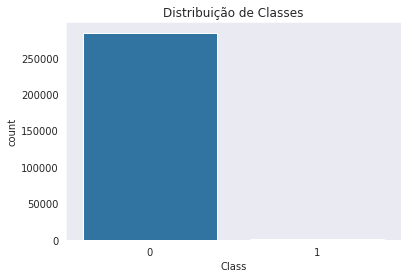

In [10]:
# ver o balanceamento das classes
print(df.Class.value_counts())
print(f"\nFraudes representam {((df[df.Class == 1].shape[0] / df.shape[0]) * 100):.4f}% do dataset.\n")

# plotar gráfico de barras para as Classes
fig, ax = plt.subplots()
sns.countplot('Class', data=df, ax=ax)
ax.set_title('Distribuição de Classes')

plt.show()

Os histogramas abaixo plotados, foram para comparar as distribuições das 2 classes sobre a `feature` (**`Time`**). Não podendo ser identificada nenhuma informação a paritr dessa distribuição.

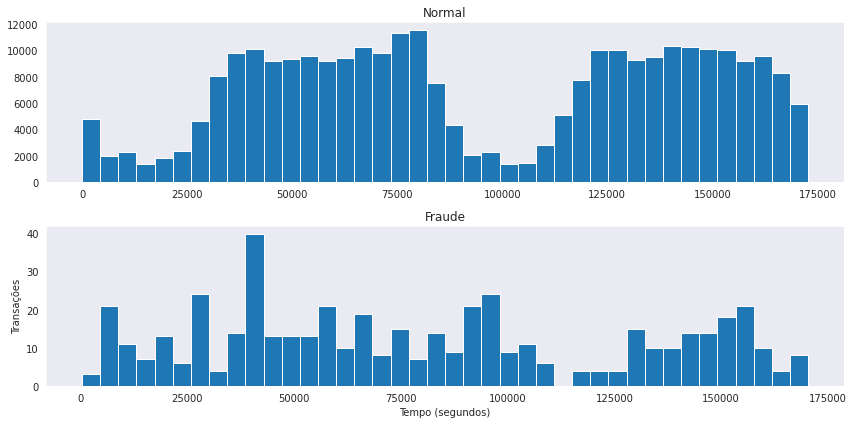

In [11]:
# Plotar histogramas:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12,6))

# Grágico 1
ax[0].hist(df.Time[df.Class == 0], bins=40)
ax[0].set_title('Normal')

# Gráfico 2
ax[1].hist(df.Time[df.Class == 1], bins=40)
ax[1].set_title('Fraude')

plt.xlabel('Tempo (segundos)')
plt.ylabel('Transações')
plt.tight_layout()

Abaixo foi plotado um gráfico de *boxplots* na intensão de verificar se existe diferença no padrão relacionado a dimensão `Amount`. Percebendo assim, diferente distribuição entre duas classes, onde será possível contribuir para treinamento do modelo de *machine learning*.

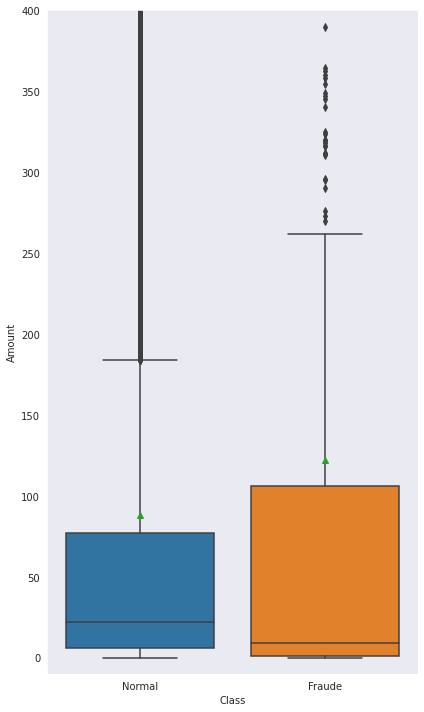

In [12]:
fig, ax = plt.subplots(figsize=(6, 10), sharex=True)

sns.boxplot(df.Class, df.Amount, showmeans=True, ax=ax)
plt.ylim((-10, 400))
plt.xticks([0, 1], ['Normal', 'Fraude'])

plt.tight_layout()

As informações estatísticas para df.Class == 1 mostram que a sua média exata está em 118.13 e a mediana em 9.21.

In [21]:
df[(df.Class == 1) & (df.Amount < 2000)]['Amount'].describe()

count     491.000000
mean      118.130550
std       240.439028
min         0.000000
25%         1.000000
50%         9.210000
75%       105.350000
max      1809.680000
Name: Amount, dtype: float64

## Preparar os Dados

**Padronizar** `Time` **e** `Amount`

*Padronizar* os dados das *feature* `Time` e `Amount` por meio da classe `StandardScaler, pois essas possuem outliers.

In [25]:
# Padronizar as colunas Time e Amount
df_clean = df.copy()

std_scaler = StandardScaler()
df_clean['std_amount'] = std_scaler.fit_transform(df_clean['Amount'].values.reshape(-1, 1))
df_clean['std_time'] = std_scaler.fit_transform(df_clean['Time'].values.reshape(-1, 1))

df_clean.drop(['Time', 'Amount'], axis=1, inplace=True)

# Ver as primeiras entradas
df_clean.head()


,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class,std_amount,std_time
0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0,0.244964,-1.996583
1,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0,-0.342475,-1.996583
2,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0,1.160686,-1.996562
3,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0,0.140534,-1.996562
4,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0,-0.073403,-1.996541


**Dividir o conjunto de dados entre treino e teste** 

Splitar os dados existentes para poder ter parametros necessarios para análise do balanceamento.



In [26]:
# Separar as variáveis X e y
X = df_clean.drop('Class', axis=1)
y = df['Class']

# Dividir o dataset entre treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, shuffle=True)


**Balancear os dados**

Usando a biblioteca imblearn é possível aplicar facilmente técnicas de balanceamento de dados. No caso, a opção neste projeto foi usar Under-sampling, preservando a classe minoritária.

É fácil ver que não há mais aquela discrepância inicial (gráfico de barras no início deste notebook).

1    369
0    369
dtype: int64


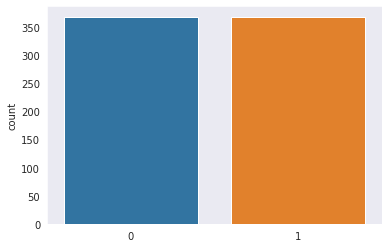

In [27]:
# Usar técnica under-sampling
rus = RandomUnderSampler()
X_rus, y_rus = rus.fit_sample(X_train, y_train)

# Ver o balanceamento das classes
print(pd.Series(y_rus).value_counts())

# Plotar a nova distribuição de classes
sns.countplot(y_rus);

A matriz de correlação abaixo auxilia na determinação da relação entre os dados, mostrando que sem um correto balanceamento dos dados, não podemos obter informação relevante para análises. 

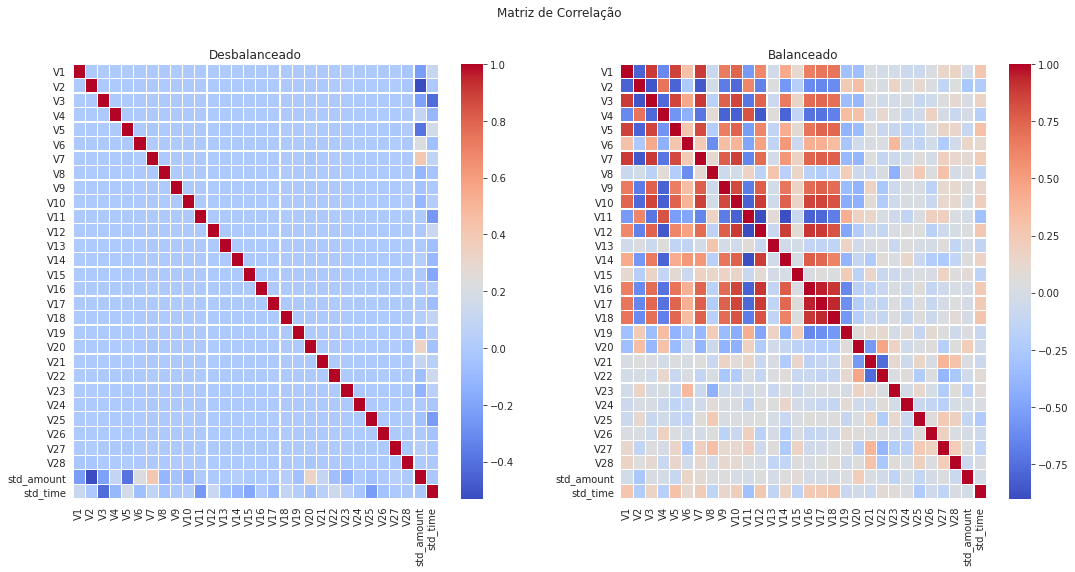

In [28]:
# plotar a matriz de correlação
corr = X_train.corr()
corr_rus = pd.DataFrame(X_rus).corr()


fig, ax = plt.subplots(nrows=1, ncols=2, figsize = (18,8))
fig.suptitle('Matriz de Correlação')

sns.heatmap(corr, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[0])
ax[0].set_title('Desbalanceado')

sns.heatmap(corr_rus, xticklabels=corr.columns, yticklabels=corr.columns,
            linewidths=.1, cmap="coolwarm", ax=ax[1])
ax[1].set_title('Balanceado')

plt.show()

## Modelo de Machine Learning

Após preparação dos dados e análise exploratória do `dataset`, o próximo passo usando a Regressão Logística é construir um classificador.

1. Instanciar o modelo (treinar sob os dados em `X_rus` e `y_rus`);
2. Realizar as previsões sobre os dados de teste;
3. Verificar as previsões.

In [ ]:
# Instanciar e treinar um modelo de Regressão Logística
np.random.seed(2)
model = LogisticRegression()
model.fit(X_rus, y_rus)

# Fazer as previsões em cima dos dados de teste
y_pred = model.predict(X_test)
y_proba = model.predict_proba(X_test)

In [ ]:
y_pred

array([0, 0, 0, ..., 0, 0, 1])

Observe a matriz de confusão para ver a taxa de acertos para transações fraudulentes, ou pela coluna recall do Relatório de Classificação. No caso desse modelo de Regressão Logística, tem-se 96% de Acurácia e 94% de AUC.

Relatório de Classificação:
               precision    recall  f1-score   support

           0     0.9999    0.9622    0.9806     71079
           1     0.0403    0.9187    0.0773       123

    accuracy                         0.9621     71202
   macro avg     0.5201    0.9404    0.5290     71202
weighted avg     0.9982    0.9621    0.9791     71202

Acurácia: 0.9621

AUC: 0.9404



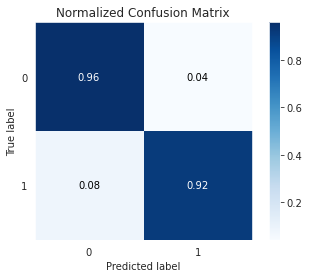

In [ ]:
# plotar a matrix de confusão
skplt.metrics.plot_confusion_matrix(y_test, y_pred, normalize=True)

# imprimir relatório de classificação
print("Relatório de Classificação:\n", classification_report(y_test, y_pred, digits=4))

# imprimir a acurácia do modelo
print("Acurácia: {:.4f}\n".format(accuracy_score(y_test, y_pred)))

# imprimir a área sob da curva
print("AUC: {:.4f}\n".format(roc_auc_score(y_test, y_pred)))


## Conclusão

Para a conclusão satisfatória desta pesquisa exploratória, foi necessário realizar uma considerável análise nos dados deste dataset, onde foi possível verificar que os dados apresentados estavam bem tratados e limpos, não apresentando outliers, mesmo assim , foi necessário balancear os dados para uma melhor eficiência na pesquisa.

Plotados gráficos de barras, boxplot, histogramas e matriz de correlação e confusão para assim demonstrar melhor resultados de conclusão.
